## Connecting to Presto

Presto ships with a CLI. Run `docker exec -it classroom-presto_presto_1 bin/presto-cli` do access it from the Presto container. the Presto CLI supports autocompletion, history, progress bars and other useful features. For quickly testing queries the CLI is very helpful.

In a environment like a Jupyter notebook, we can use a Presto Python client. The Presto client library implements the Python DBAPI2.0 interface that is used by common database client libraries for querying MySQL, PostgreSQL and SQLite.

DBAPI2.0 defines a API with a `Connection`. Queries then happen with a `cursor`. Presto supports transaction. The level of isolation depends on the connectors involved in a query.

The three mandatory arguments to create a connection are *host*, *port*, and *user*.
Other arguments such as *source* allow to identify the origin of the query. A common use case is to use it to tell which service, tool, or code sent the query.

Let's create a connection:

In [ ]:
import prestodb.dbapi as presto

conn = presto.Connection(host="presto", port=8080, user="demo")
cur = conn.cursor()
cur

## Configuration

Presto's general configuration is documented in the [deployment](https://prestodb.github.io/docs/current/installation/deployment.html) page. There are 4 types of configuration files:
- Node Properties: to configure the coordinator (main server) and worker nodes.
- JVM Config: command line options for the Java Virtual Machine that runs Presto.
- Config Properties: configuration for the Presto server
- Catalog Properties: configuration for Connectors (data sources)

In the repository, the configuration is in `etc/`. The main file to configure Presto is `config.properties`:

```
coordinator=true
node-scheduler.include-coordinator=true
http-server.http.port=8080
discovery-server.enabled=true
discovery.uri=http://localhost:8080
```

The discovery is what allows worker nodes to find the coordinator and register themselves. Then they will participate in the execution of queries.

## Catalogs

A catalog is mapped to a connector. The name of configuration file for a catalgo defines the catalog's name. Here `etc/catalog/mysql.properties` configures the `mysql` catalog. We could name it `events` or `users`:

```
connector.name=mysql
connection-url=jdbc:mysql://mysql:3306
connection-user=USER
connection-password=PASSWORD
```

We did the same with `etc/catalog/mongodb.properties`:

```
connector.name=mongodb
mongodb.seeds=mongodb
```

Adding a catalog is a simple as adding a file with the catalog properties and named after the catalog's name.


Below we list the available catalogs on the Presto cluster we are running:

In [3]:
cur.execute("SHOW catalogs")
cur.fetchall()

[['hive'], ['mongodb'], ['mysql'], ['system'], ['tcph']]

## How Does Presto Execute a Query?

If you are curious about what Presto translate a SQL query to and what it will run, you can you `EXPLAIN`:

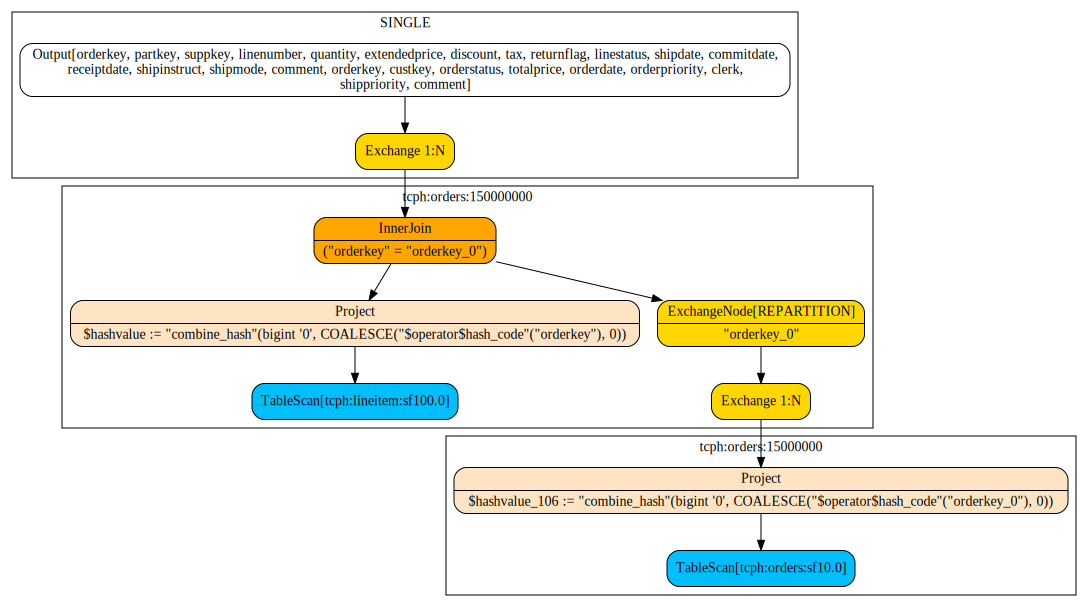

In [11]:
conn = presto.Connection(host="presto", port=8080, user="demo", catalog="tcph", schema="sf10")
cur = conn.cursor()
cur.execute("explain (type distributed, format graphviz) select * from tcph.sf100.lineitem l join orders o on l.orderkey = o.orderkey")
plan = cur.fetchall()

import graphviz

graphviz.Source(plan[0][0])

Here we asked Presto to return the query plan in graphviz format.

Each box is a *stage* and the boundaries delimit when Presto has to exchange data between nodes.

## Querying Presto

We imported data from [GH Archive](http://www.gharchive.org/) as projects that records GitHub public timeline. The data are raw JSON and we show below how to extract fields from the JSON structs with JSON Path in Presto:

In [32]:
cur = conn.cursor()
cur.execute("SELECT json_extract(json_parse(event), '$.type') FROM mysql.presto.events TABLESAMPLE BERNOULLI (1) LIMIT 1")
cur.fetchall()

[['"CreateEvent"']]

If Presto fails to parse JSON it will fail the query. To catch errors and return `null` instead (that will be `None` in Python), we use the function `TRY()`.

In [22]:
cur = conn.cursor()
cur.execute("""
    SELECT ev_type, repo_name, count(*) FROM (
      SELECT
        TRY(json_extract_scalar(ev, '$.repo.name')) as repo_name,
        TRY(json_extract_scalar(ev, '$.type')) as ev_type FROM (
          SELECT try(json_parse(event)) as ev FROM mysql.presto.events))
    WHERE repo_name is not null and ev_type = 'PushEvent'
    GROUP BY ev_type, repo_name
    ORDER BY 3 DESC
    LIMIT 10
""")
rows = cur.fetchall()
import pandas as pd
from IPython.display import display

print(rows)
df = pd.DataFrame(sorted(rows, key=lambda x: x[2], reverse=True))
display(df)

[['PushEvent', 'willcbaker-ext/subt', 3062], ['PushEvent', 'chuan12/shenzhouzd', 2216], ['PushEvent', 'dotclear/dotclear', 1919], ['PushEvent', 'geos4s/18w856162', 1615], ['PushEvent', 'yanonono/booth-update', 1589], ['PushEvent', '8emezzo/8emezzo.github.io', 1279], ['PushEvent', 'Lombiq/Orchard', 1248], ['PushEvent', 'hashibiroko/tanoshi', 1200], ['PushEvent', 'GitClock/GitClock', 1199], ['PushEvent', 'c1d5dc29-94f0-4b46-bc0a-397a2885eade/c1d5dc29-94f0-4b46-bc0a-397a2885eade', 1198]]


,0,1,2
0,PushEvent,willcbaker-ext/subt,3062
1,PushEvent,chuan12/shenzhouzd,2216
2,PushEvent,dotclear/dotclear,1919
3,PushEvent,geos4s/18w856162,1615
4,PushEvent,yanonono/booth-update,1589
5,PushEvent,8emezzo/8emezzo.github.io,1279
6,PushEvent,Lombiq/Orchard,1248
7,PushEvent,hashibiroko/tanoshi,1200
8,PushEvent,GitClock/GitClock,1199
9,PushEvent,c1d5dc29-94f0-4b46-bc0a-397a2885eade/c1d5dc29-...,1198


In [ ]:
cur = conn.cursor()
cur.execute("""
  CREATE TABLE mongodb.events.all AS
    SELECT TRY(json_extract_scalar(TRY(json_parse(event)), '$.re.name')) FROM mysql.presto.events
""")
cur.fetchall()